In [1]:
import warnings
warnings.filterwarnings('ignore')
import spacy
from keras.applications.vgg16 import VGG16
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import matplotlib.pyplot as plt
from keras.utils import plot_model,multi_gpu_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import Model
from keras.models import load_model
from keras.layers import Input,GlobalAveragePooling2D,Layer,InputSpec
from keras.layers.core import Dense,Flatten,Dropout
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils
import keras.backend as K
import keras.layers as kl
from keras.preprocessing import sequence
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from time import time
import pickle
from keras.models import model_from_json
from keras.losses import sparse_categorical_crossentropy
from PIL import Image
# from AttentionModule import SelfAttention, SoftAttention
import os
visible_gpu_devices = '0,1,3'
os.environ["CUDA_VISIBLE_DEVICES"]=visible_gpu_devices
# import cv2
from tqdm.notebook import tqdm
import AttentionMed as AM
import NetworkModules as NM
from importlib import reload
reload(AM)
reload(NM)
from time import time,localtime,strftime
from ipywidgets import IntProgress
# from coord import CoordinateChannel2D

Using TensorFlow backend.


In [2]:
n_gpu = len(visible_gpu_devices.split(','))
n_cpu=1
tf_config= tf.ConfigProto(device_count = {'GPU': n_gpu , 'CPU': n_cpu})
tf_config.gpu_options.allow_growth=True
s=tf.Session(config=tf_config)
K.set_session(s)




In [3]:


def multiheadSelfAttention(prev_layer,padding_masks,layer_number=0,heads=8):
    assert prev_layer != None
    sa_arr = []
    for head in range(heads):
        if padding_masks!=None:
            x,q,k,v,s,b,beta,o = AM.SelfAttention(ch=int(prev_layer.shape[-1]),name='sa{0}{1}'.format(layer_number,head))([prev_layer,padding_masks])
        else:
            x,q,k,v,s,b,beta,o = AM.SelfAttention(ch=int(prev_layer.shape[-1]),name='sa{0}{1}'.format(layer_number,head))(prev_layer)
#         print(q.shape)
#         print(k.shape)
#         print(v.shape)
#         print(s.shape)
#         print(b.shape)
#         print(beta.shape)
#         print(o.shape)
        sa = kl.BatchNormalization()(o)
        sa_arr.append(o)
    return sa_arr

def condResAndNormSelfAttn(sa_layer,residual_inp,out_channels,attn_type,layer_number=0,condense=False,method='add'):
    assert attn_type!=None
    if condense:
        x = kl.Concatenate(name='concat_{0}_{1}'.format(attn_type,layer_number))(sa_layer)
        x = AM.CondenseAttention1D(ch_in=int(x.shape[-1]),name='cond_{0}_{1}'.format(attn_type,layer_number),ch_out=out_channels)(x)
    else:
        x = sa_layer
    x, g1, g2 = AM.ResidualCombine(method=method
                                   ,name='res_comb_{0}_{1}'.format(attn_type,layer_number))([residual_inp, x])
#     x = kl.Conv1D(filters=512,activation='relu',strides=1,kernel_size=1,name='ff_conv_{0}'.format(layer_number))(x)
    x = kl.BatchNormalization()(x)
    return x

def enc_dec_attn(encoder,decoder,out_channels,layer_number=0,heads=8):
    assert encoder != None
    assert decoder != None
    eca_arr = []
    for head in range(heads):
        q,k,v,beta,scores,o = AM.EncDecAttention(enc_ch=int(encoder.shape[-1]),dec_ch=int(decoder.shape[-1]),name='eca{0}{1}'.format(layer_number,head))([decoder,encoder])
        eca = kl.BatchNormalization()(o)
        eca_arr.append(eca)
    return eca_arr

def multiheadAttention(prev_layer,context_vector,layer_number=0,heads=8):
    assert prev_layer != None
    assert context_vector != None
    a_arr = []
    for head in range(heads):
        a,a_map = AM.Attention(ch=int(prev_layer.shape[-1]),name='a{0}{1}'.format(layer_number,head))([context_vector,prev_layer])
        a = kl.BatchNormalization()(a)
        a_arr.append(a)
    return a_arr

def condResAndNormAttn(a_layer,context_vector,out_channels,layer_number=0,method='add'):
    x = kl.Concatenate(name='concat_attn_{0}'.format(layer_number))(a_layer)
    x = AM.CondenseAttention1D(ch_in=int(x.shape[-1]),name='condense_attn1D_{0}'.format(layer_number),ch_out=out_channels)(x)
    x = kl.Lambda(lambda x:K.squeeze(x,axis=1),name="squeeze_attn_{0}".format(layer_number))(x)
    x, g1, g2 = AM.ResidualCombine(method=method
                                   ,name='residual_combine_attn_{0}'.format(layer_number))([context_vector, x])
    x = kl.BatchNormalization()(x)
    return x

def decoder_block(sa_input,encoder_output,padding_masks=None,layer_number=1,heads=8):
    mhsa = multiheadSelfAttention(prev_layer=sa_input,padding_masks=None,layer_number=layer_number,heads=heads)
    # add+norm
    add_norm_mhsa = condResAndNormSelfAttn(attn_type='sa',condense=True,sa_layer=mhsa,residual_inp=sa_input,out_channels=int(sa_input.shape[-1]),layer_number=layer_number)
    # enc-dec attn
    eca = enc_dec_attn(encoder=encoder_output,decoder=add_norm_mhsa,out_channels=int(sa_input.shape[-1]),layer_number=layer_number) 
    # add+norm
    add_norm_eca = condResAndNormSelfAttn(attn_type='enc',condense=True,sa_layer=eca,residual_inp=add_norm_mhsa,out_channels=int(sa_input.shape[-1]),layer_number=layer_number)
    # apply same feed forward on each position
    ff_dec = kl.TimeDistributed(kl.Dense(512,activation='relu'))(add_norm_eca)
    # add+norm
    add_norm_eca = condResAndNormSelfAttn(attn_type='NA',condense=False,sa_layer=ff_dec,residual_inp=add_norm_eca,out_channels=int(sa_input.shape[-1]),layer_number=layer_number)
    return add_norm_eca

def get_angles(pos, i, dimensions):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(dimensions))
    return pos * angle_rates

def positional_encoding(position, dimensions):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(dimensions)[np.newaxis, :],
                          dimensions)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return pos_encoding

In [4]:
nlp = spacy.load('en_core_web_md')

In [5]:
path=os.getcwd() #Get the path
path

'/media/MyDataStor1/mshaikh2/project_xray/ChestXRay/notebooks'

In [6]:
merged_ds = pd.read_csv('../../dataset/descriptions/region_descriptions_50000.csv')

In [7]:
# sent_len_arr=[]
# wo_len_arr = []
# for row in tqdm(merged_ds['impression'].values):
#     doc = nlp(row)
#     sentences = [sent.string.strip() for sent in doc.sents]
#     sent_len_arr.append(len(sentences))
#     sentence = ' '.join(sentences[:7])
#     sdoc = nlp(sentence)
#     ls_sdoc = [str(x) for x in list(sdoc)]
#     wo_len_arr.append(len(ls_sdoc))

In [8]:

# df_sent_len = pd.DataFrame(sent_len_arr,columns=['count'])
# df_word_len = pd.DataFrame(wo_len_arr,columns=['count'])
# df_sent_len.shape,df_word_len.shape

In [9]:
# df_word_len.describe()

In [10]:
# df_sent_len[df_sent_len['count']>7].shape
# df_word_len[df_word_len['count']>20]


In [11]:
# ch_to_co = df_ccount
# ch_to_co.index = ch_to_co.chars
# ch_to_co = ch_to_co['index'].to_dict()
# display(ch_to_co)
# co_to_ch = df_ccount
# co_to_ch.index = co_to_ch['index']
# co_to_ch = co_to_ch['chars'].to_dict()
# display(co_to_ch)

In [12]:
# tokens = nlp('startseq ' 
#              + ' '.join(c_repo_ds.impression.values).lower().replace('/',' ')
#              + ' endseq.' 
#              + ' startseq' 
#              + ' '.join(c_repo_ds.findings.values).lower().replace('/',' ')
#              + ' endseq.')

In [13]:
# vocab = [str(x) for x in tokens]
# vocab

In [14]:
# word_count = {}
# for word in vocab:
#     if word not in word_count.keys():
#         word_count[word]=1
#     else:
#         word_count[word]+=1
# df_wcount = pd.DataFrame()
# df_wcount['words']=word_count.keys()
# df_wcount['w_count']=word_count.values()
# df_wcount = df_wcount.sort_values(by='w_count',ascending=False).reset_index()
# df_wcount['index']+=1

# df_wcount.to_csv('../dataset/vocab_count.csv',index=False)
df_wcount = pd.read_csv('../../dataset/descriptions/visual_genome_vocab_count.csv')

display(df_wcount)
vocab_size=df_wcount.shape[0]
max_wlen = 60
print(vocab_size,max_wlen)

,index,words,w_count
0,3434,.,450076
1,13908,a,200676
2,14934,the,198458
3,16021,on,122073
4,10923,of,88941
...,...,...,...
20789,6648,casa,1
20790,6647,coppertone,1
20791,10397,substitutes,1
20792,20793,startseq,50000


20794 60


In [15]:
new_words= [word for word in df_wcount['words'].values if not word.isalnum()]
print(len(new_words),new_words)

597 ['.', '..', "'s", ' ', ',', '-', '"', "'", '&', '/', 'w/', '[', '\n', '@', "n't", ']', '?', ':', ';', 'p.', 't.v', '...', '  ', '!', '$', '_', 'w.', 'u.s', 'n.', 'a.', "o'clock", 'c.', '#', 'x.', '(', 'r.', ')', 'e.', 's.', 't.', 'b.', '1/2', 'l.', 'man`s', 'woman`s', 'm.', 'c-130', '=', 'black+white', '   ', '....', 'and/or', 'o.', 'red+white', 'dog`s', 'i.', 'girl`s', 'v.', 'm&m', 'g.', '......', 'f.', '+', '.....', 'sr-71', 'y.', "'m", 'co.', 'h.', 'cow`s', 'j.', 'd.', '`', 'boy`s', '%', 'man;s', '--', '\n\n', 't-', '2:35', '1:45', 'u.', 'w/o', 'red+black', 'at&t', '11:50am', '1.00', '12:00', '3:17', '7:05', "'re", 'brown+white', '1/3', 'back+one', 'i.d', '/or', '1:55', 'green+white', '10:50', '12:43', '                                    ', 'b+w', '4-post', 'child`s', '11:20', '3:00', 'trunk+branches', '12:40', 'www.myprofe.com', 'person`s', 'k.', 'catcher`s', '9.99', 'free!.', '    ', 'a&m', '3-way', '3:55', 'sea+sky', '11:05', '4-way', '2:20', 'tool+a', 'house/', 'him!.', '11

In [16]:
w_to_co = df_wcount
w_to_co.index = w_to_co.words
w_to_co = w_to_co['index'].to_dict()
# print(w_to_co)
co_to_w = df_wcount
co_to_w.index = co_to_w['index']
co_to_w = co_to_w['words'].to_dict()
# print(co_to_w)

In [17]:
# df = pd.DataFrame(sorted(finding_len,reverse=True))
# display(df.head(50))
# df.plot(kind='hist',figsize=(6,6))
co_to_w[13]

'troaster'

In [18]:
embedding_size = 300
# embedding_matrix = np.zeros((vocab_size+1, embedding_size)) # last one : to cater to empty/-1
# for word,idx in w_to_co.items():
#     token = nlp(word)
#     embedding_matrix[idx] = token.vector
# embedding_matrix[vocab_size] = np.zeros(embedding_size)
embedding_matrix = pd.read_pickle('../../dataset/descriptions/visual_genome_initial_emb_mat.p')
embedding_matrix = embedding_matrix.values
# print(embedding_matrix.shape)
# df_emb = pd.DataFrame(embedding_matrix)
# df_emb.to_pickle('../dataset/initial_emb_mat.p')

# Parameters

In [19]:
img_arch = 'vgg'
text_arch = '1dcnn'
model_name = '{0}_{1}_text_img_attention'.format(img_arch,text_arch)
EPOCHS = 50
lr = 0.0001
img_dropout_rate=0.5
text_dropout_rate=0.5
elu_alpha = 1.0

# Model Initialization

In [20]:
# image_input = kl.Input(shape=(256,256,3),name='image_input')
# if img_arch=='vgg':
#     encoded_image = NM.ImageEncoder.model(image_input)
# #     imgNet = VGG16(include_top=False,input_shape=(256,256,3),weights='imagenet')
# elif img_arch == 'densenet121':
#     imgNet = DenseNet121(include_top=False,input_shape=(256,256,3))
#     imgNet.trainable = True
# elif img_arch == 'densenet':
#     imgNet = DenseNet()
# elif img_arch == 'irv2':
#     imgNet =InceptionResNetV2(include_top=False,input_shape=(256,256,3))
#     imgNet.trainable = True

In [21]:
# encoded_image

In [22]:
bottleneck_units = 512
words_input = kl.Input(shape=(max_wlen,),name='words_input')
padding_masks = kl.Input(shape=(max_wlen,1),name='padding_masks')
positional_encoding = Input(shape=(max_wlen,512),name='positional_encoding')

image_input = kl.Input(shape=(256,256,3),name='image_input')
encoded_image = NM.ImageEncoder.model(image_input)
target = NM.TextDecoder.model(embedding_size=embedding_size
                            ,vocab_size=vocab_size
                            ,encoded_image=encoded_image
                            ,words_input=words_input
                            ,masks=padding_masks
                            ,positional_encoding=positional_encoding
                            ,bottleneck_units=bottleneck_units)
model = Model([image_input,words_input,padding_masks,positional_encoding],target,name='model')

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        image_input[0][0]                
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_reduction_pool (MaxPooli (None, 128, 128, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [24]:
# words_input = kl.Input(shape=(max_wlen,300),name='words_input')
# n = Dense(10,activation='relu')(words_input)
# print(n)
# g1 = Dense(1,activation='tanh')
# x = K.expand_dims(axis=-1,x=words_input)
# print(x)
# g1_out = g1(x)
# print(g1_out)
# # print(g1.get_weights()[0][0])
# # g1_weight = K.tf.convert_to_tensor(g1.get_weights()[0][0])
# # print(tuple(g1_weight.shape.as_list()))
# from keras.models import M
target

<tf.Tensor 'dense_116/BiasAdd:0' shape=(?, 20795) dtype=float32>

In [25]:
# kl.Input(shape=(256,256,3),name='images_input')

In [26]:
# textNet = getTextNet(image_input)
# textNet.summary()

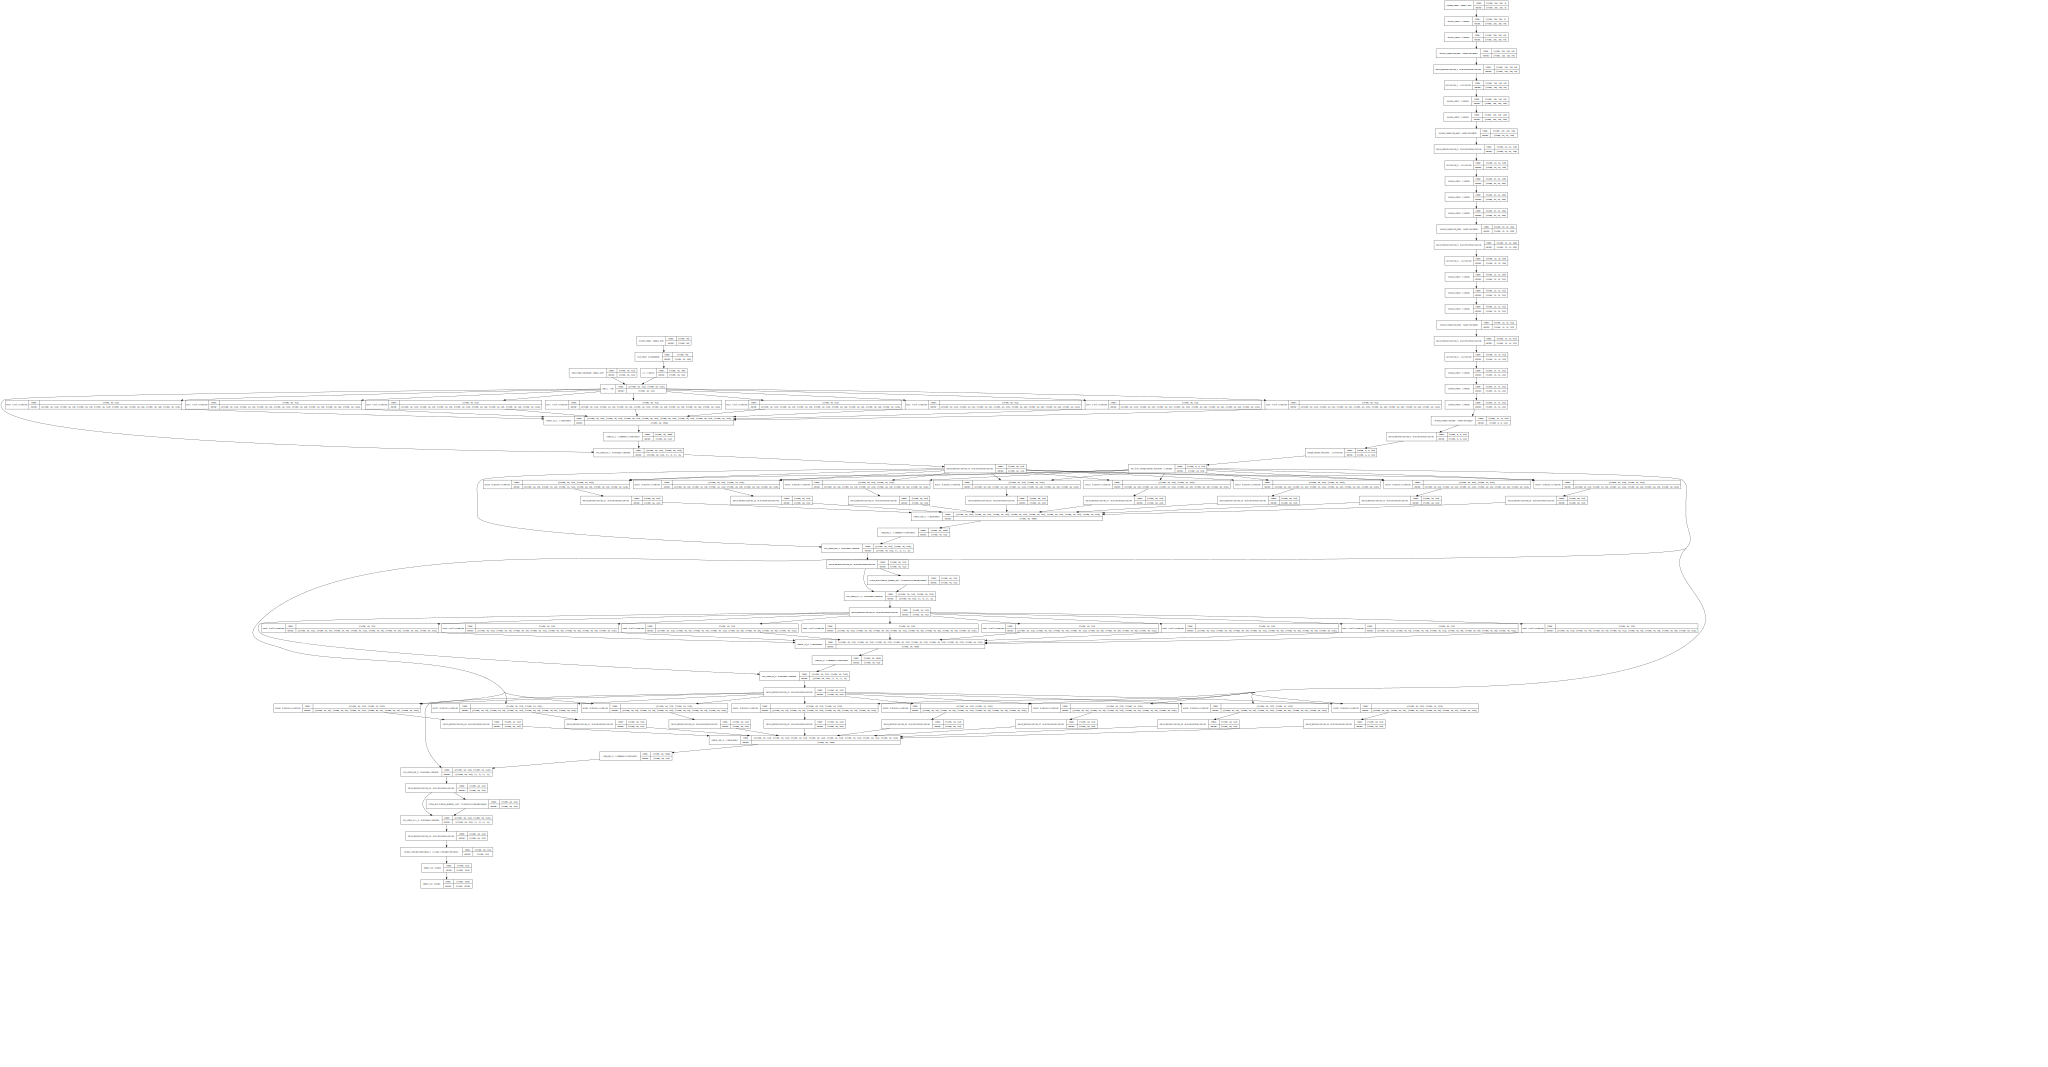

In [27]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True,dpi=60).create(prog='dot', format='svg'))

# Define Complete Joint Network

In [28]:
# image_dropout_rate = 0.3
# image_input = kl.Input(shape=(256,256,3),name='image_input')
# image_features = imgNet(image_input)
# image_features = kl.Dropout(image_dropout_rate)(image_features)

# text_dropout_rate = 0.1
# padding_masks = kl.Input(shape=(max_wlen,1),name='padding_masks')
# words_input = kl.Input(shape=(max_wlen,),name='words_input')
# text_features = textNet([words_input,padding_masks])
# # text_features = kl.Dropout(text_dropout_rate)(text_features)
# print(image_features.shape)
# print(text_features.shape)

In [29]:
# def multiheadImg2TextCA(tf=None,imf=None,padding_masks=None,layer_number=0,heads=8):
#     ca_arr = []
#     for head in range(heads):
#         ca,beta_im = AM.Img2TextCA(text_ch=int(tf.shape[-1]),img_ch=int(imf.shape[-1]),name='img2text_{0}{1}'.format(layer_number,head))([imf,tf,padding_masks])
#         ca = kl.BatchNormalization()(ca)
#         ca_arr.append(ca)
#     return ca_arr
# def feedforwardImg2TextCA(ca_layer=None,imf=None,out_channels=512,layer_number=0,method='add'):
#     x = kl.Concatenate(name='img2text_concat_{0}'.format(layer_number))(ca_layer)
#     x = AM.CondenseAttention2D(ch_in=int(x.shape[-1]),name='condense_Img2Text_2D_{0}'.format(layer_number),ch_out=out_channels)(x)
#     x, g1, g2 = AM.ResidualCombine(method=method
#                                    ,name='residual_combine_img2text_{0}'.format(layer_number))([imf, x])
#     x = kl.BatchNormalization()(x)
#     return x

# ###########################################################################################################
# def multiheadText2ImgCA(tf=None,imf=None,padding_masks=None,layer_number=0,heads=8):
#     ca_arr = []
#     for head in range(heads):
#         tx,q,k,v,s,scores,beta,o = AM.Text2ImgCA(text_ch=int(tf.shape[-1]),img_ch=int(imf.shape[-1]),name='text2img_{0}{1}'.format(layer_number,head))([tf,imf,padding_masks])
#         ca = kl.BatchNormalization()(o)
#         ca_arr.append(ca)
#     return ca_arr
# def feedforwardText2ImgCA(ca_layer=None,tf=None,out_channels=512,layer_number=0,method='add'):
#     assert tf!=None
#     x = kl.Concatenate(name='text2img_concat_{0}'.format(layer_number))(ca_layer)
#     x = AM.CondenseAttention1D(ch_in=int(x.shape[-1]),name='condense_Text2Img_1D_{0}'.format(layer_number),ch_out=out_channels)(x)
#     x, g1, g2 = AM.ResidualCombine(method=method
#                                    ,name='residual_combine_text2img_{0}'.format(layer_number))([tf, x])
#     x = kl.BatchNormalization()(x)
#     return x

In [30]:
# i2t returns text features which are pertinent to the image sections
# i2t = multiheadImg2TextCA(tf=text_features,imf=image_features,padding_masks=padding_masks,layer_number=1)

# # so we combine it with the existing image features
# i2t_comb = feedforwardImg2TextCA(ca_layer=i2t,imf=image_features,out_channels=512,layer_number=1,method='add')
# img2text_pool = kl.GlobalAveragePooling2D(name='img2text_global_pool')(i2t_comb)


In [31]:
# # t2i returns image features which are pertinent to the textual words
# t2i = multiheadText2ImgCA(tf=text_features,imf=image_features,padding_masks=padding_masks,layer_number=1)

# # so we combine it with the existing textual words
# t2i_comb = feedforwardText2ImgCA(ca_layer=t2i,tf=text_features,out_channels=512,layer_number=1,method='add')
# text2img_pool = kl.GlobalAveragePooling1D(name='text2img_global_pool')(t2i_comb)

In [32]:
# a_out_1,beta_1 = AM.Text2ImgCA(text_ch=int(text_features.shape[-1]),img_ch=int(image_features.shape[-1]),name='text2img_1')([text_features,image_features,padding_masks])
# # a_out_1 = kl.BatchNormalization()(a_out_1)
# # a_out_1 = kl.ELU(alpha=elu_alpha)(a_out_1)
# # print(a_out_1.shape)
# a_out_2,beta_2 = AM.Text2ImgCA(text_ch=int(text_features.shape[-1]),img_ch=int(image_features.shape[-1]),name='text2img_2')([text_features,image_features,padding_masks])
# # a_out_2 = kl.BatchNormalization()(a_out_2)
# # a_out_2 = kl.ELU(alpha=elu_alpha)(a_out_2)
# # print(a_out_2.shape)
# a_out_3,beta_3 = AM.Text2ImgCA(text_ch=int(text_features.shape[-1]),img_ch=int(image_features.shape[-1]),name='text2img_3')([text_features,image_features,padding_masks])
# # a_out_3 = kl.BatchNormalization()(a_out_3)
# # a_out_3 = kl.ELU(alpha=elu_alpha)(a_out_3)
# # print(a_out_3.shape)
# a_out_4,beta_4 = AM.Text2ImgCA(text_ch=int(text_features.shape[-1]),img_ch=int(image_features.shape[-1]),name='text2img_4')([text_features,image_features,padding_masks])
# # a_out_4 = kl.BatchNormalization()(a_out_4)
# # a_out_4 = kl.ELU(alpha=elu_alpha)(a_out_4)
# # print(a_out_4.shape)
# a_conc_text = kl.Concatenate(name='text2img_concat')([a_out_1,a_out_2,a_out_3,a_out_4])

# text2img_condense = AM.CondenseAttention1D(ch_in=int(a_conc_text.shape[-1]),ch_out=512)(a_conc_text)
# text2img_comb, xt2ig1, xt2ig2 = AM.ResidualCombine()([text_features, text2img_condense])
# text2img_comb = kl.ELU(alpha=elu_alpha)(text2img_comb)
# text2img_comb = kl.Conv1D(filters=bottleneck_units,kernel_size=1,strides=1,padding='same')(text2img_comb)
# text2img_comb = kl.BatchNormalization()(text2img_comb)
# text2img_comb = kl.Dropout(dropout_rate)(text2img_comb)
# text2img_pool = kl.GlobalAveragePooling1D(name='text2img_global_pool')(text_features)
# text2img_pool = text_features

In [33]:
# dropout_rate = 0.3
# # all_concat = kl.Concatenate()([img2text_pool,text2img_pool])
# cross_pool = kl.Dense(1024)(text2img_pool)
# cross_pool = kl.Activation('relu')(cross_pool)
# # cross_pool = kl.Dense(512,activation='relu')(cross_pool)
# # cross_pool = kl.Dropout(dropout_rate)(cross_pool)
# target = kl.Dense(vocab_size+1,name='target_word')(cross_pool)
# model = Model([image_input,words_input,padding_masks],target)


In [34]:
# json_file = open('../model_json/{0}_{1}_text_img_attention.json'.format(img_arch,text_arch), 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)

In [35]:
# loaded_model_json
vocab_size


20794

In [36]:
# loaded_model==model
adam = adam = Adam(
    lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False
)

In [37]:
l = model.get_layer('w2v_emb')
l.set_weights([embedding_matrix])
l.trainable = False
# if not os.path.exists('../checkpoints/{0}.h5'.format(model_name)):
#     print('New model {0}.'.format(model_name))
# else:
#     print('Existing model {0}. trained weights will be loaded'.format(model_name))
#     model.load_weights('../checkpoints/{0}.h5'.format(model_name), skip_mismatch=True, by_name=True)
# l.trainable = True

In [38]:
# w_to_co
# textNet.load_weights('../checkpoints/irv2_1dcnn_attention_text_module.h5')
# imgNet.load_weights('../checkpoints/irv2_1dcnn_attention_img_module.h5')

In [39]:
loss_function =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# model.summary()
model.compile(loss=loss_function, optimizer=adam,metrics=['accuracy'])
# model.load_weights('../checkpoints/{0}.h5'.format(model_name))

In [40]:
# SVG(model_to_dot(model, show_layer_names=True, show_shapes=True,dpi=60,expand_nested=True).create(prog='dot', format='svg'))


In [41]:
model_json = model.to_json()
with open("../model_json/visual_genome_{0}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)


In [42]:
model_name

'vgg_1dcnn_text_img_attention'

In [43]:
im = 1
image = Image.open('../../dataset/train_images/VG_100K/{0}.jpg'.format(im))
image=image.convert('RGB')

(256, 256, 3)


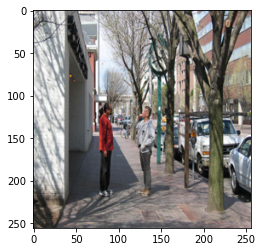

In [44]:
img = image.resize((256,256),Image.BICUBIC)
print(np.asarray(img).shape)
plt.imshow(img)

In [45]:
def datagen(img_lst,batch_size=4):
    counter=0
    x1,x2,y,sents,masks, img_names = [],[],[],[],[],[]
    idx = 0
    while True:
        im = img_lst[idx]
#         print(im)
        image = Image.open('../../dataset/train_images/VG_100K/{0}.jpg'.format(im))
        image = image.convert('RGB')
        photo = image.resize((256,256),Image.BICUBIC)
        photo = np.asarray(photo)/255.0
#         print('{0}.jpg -> '.format(im),photo.shape)
#         print(merged_ds[merged_ds.filename==im])
        sent = merged_ds[merged_ds.ID==im]['Desc'].values[0].lower()
        
        ts = nlp(sent)
#         print(ts)
        ts = [str(x) for x in list(ts)]
#         print(tss)
        ts = ts[:max_wlen-1]
        sent_words = ['startseq']
        for t in ts:
#             print(t)
#             t = 'sdadasasdasads'
            if (t not in w_to_co.keys()) : #or ('xx' in t):
#                 print('not present:',t)
                pass
            else:
                sent_words.append(t)
        sent_words.append('endseq')
#         print(sent_words)

        seq = [w_to_co[x] for x in sent_words]
        # split one sequence into multiple X, y pairs
        for i in range(1, len(seq)):
            
            in_seq, out_seq = seq[:i], seq[i]
#             print(out_seq)
            in_seq = sequence.pad_sequences([in_seq], maxlen=max_wlen,padding='pre',value=0)[0]
            mask = [1e-2 if x<1 else  1 for x in in_seq]
            mask = np.expand_dims(mask,-1)
#             out_seq = np_utils.to_categorical([out_seq], num_classes=vocab_size+1)[0]
            x1.append(photo)
            img_names.append('{0}.jpg'.format(im))
            x2.append(in_seq)
            masks.append(mask)
            y.append(out_seq)
            sents.append(sent)
        counter+=1
        idx+=1
#         print(idx)
        if idx==len(img_lst):
            idx=0
        if counter==batch_size:
            counter=0
            inputs = {'image_input': np.array(x1),
                      'words_input': np.array(x2),
                      'padding_masks':np.array(masks),
                      'image_names':np.array(img_names)
                     }
            outputs = {'target_word':np.array(y),
                      'actual_sentence':np.array(sents)}
            yield inputs, outputs
            x1,x2,y,sents,masks,img_names = [],[],[],[],[],[]

In [46]:


with open('../../dataset/descriptions/visual_genome_train_images.p', 'rb') as filehandle:
    # read the data as binary data stream
    train_images_list = pickle.load(filehandle)
with open('../../dataset/descriptions/visual_genome_val_images.p', 'rb') as filehandle:
    # read the data as binary data stream
    val_images_list = pickle.load(filehandle)
with open('../../dataset/descriptions/visual_genome_test_images.p', 'rb') as filehandle:
    # read the data as binary data stream
    test_images_list = pickle.load(filehandle)
# train_images_list=list(train_images_list)+list(val_images_list)
print('train:',len(train_images_list),
      '+ val:',len(val_images_list),
      '+ test:',len(test_images_list),
      ' = ',(len(train_images_list)+len(val_images_list)+len(test_images_list)))
train_batch_size = 64
val_batch_size = 64
test_batch_size = 1
train_gen = datagen(train_images_list,batch_size=train_batch_size)
val_gen = datagen(val_images_list,batch_size=val_batch_size)
test_gen = datagen(test_images_list,batch_size=test_batch_size)

train: 35000 + val: 10000 + test: 5000  =  50000


In [47]:
# # test_images_list = merged_ds.filename.values
# # test_images_list = list(test_images_list)
# # for x in train_images_list:
# #     test_images_list.remove(x)
# # for x in val_images_list:
# #     test_images_list.remove(x)
# # len(test_images_list)
# imgs = merged_ds.ID.values
# imgs

In [48]:

# np.random.shuffle(imgs)

# train_images_list = imgs[:int(0.7*len(imgs))]
# val_images_list = imgs[int(0.7*len(imgs)):int(0.9*len(imgs))]
# test_images_list = imgs[int(0.9*len(imgs)):]
# train_images_list.shape,val_images_list.shape,test_images_list.shape
# with open('../../dataset/descriptions/visual_genome_train_images.p', 'wb') as file:
#     # store the data as binary data stream
#     pickle.dump(train_images_list, file)
# with open('../../dataset/descriptions/visual_genome_val_images.p', 'wb') as file:
#     # store the data as binary data stream
#     pickle.dump(val_images_list, file)
# with open('../../dataset/descriptions/visual_genome_test_images.p', 'wb') as file:
#     # store the data as binary data stream
#     pickle.dump(test_images_list, file)
# # # tx,ty = next(train_gen)
# # # tx['padding_masks'][30].shape

In [49]:

# display(tx['image_input'].shape
#         ,tx['words_input'][30]
#         ,tx['padding_masks'][30]
#         ,' '.join([co_to_w[x] if x !=0 else '' for x in tx['words_input'][30]])
#         ,ty['actual_sentence'][30])
# train_images_list=list(train_images_list)+list(val_images_list)

In [50]:
len(test_images_list),len(train_images_list)

(5000, 35000)

In [51]:
# # def _ctc_lambda_func(args):
# #     labels, y_pred, input_length, label_length = args
# #     return K.tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)
# vggnet.summary()
# w_to_co['xxxx']

# np.clip(0,a_max=1,a_min=1e-8)

In [52]:
# print(co_to_w[273])
# print(embedding_matrix[1380])
# for u,v in zip(tx['words_input'][0],tx['padding_masks'][0]):
#     print(u,v)
pd.options.display.max_colwidth=1000
merged_ds.head()

,ID,Desc
0,1,the clock is green in colour. shade is along the street . man is wearing sneakers. cars headlights are off. bikes are parked at the far edge. A sign on the facade of the building. A tree trunk on the sidewalk. A man in a red shirt. A brick sidewalk beside the street. The back of a white car.
1,2,walk sign is lit up. man wearing silver backpack. red car parked on road. 3 green trees line street. crosswalk. A bricked sidewalk. . A building with a lot of glass windows. . A white car parked on the side of the road. . A white street light. . A sign on the side of the road. .
2,3,"multi-line office phone system. electrical and data line outlets. desktop CPU, monitor and keyboard. two-drawer filing cabinet. black leather computer case. A computer keyboard and mouse. A wireless telephone on its base. A computer tower under a desk. A file cabinet next to the desk. A multiple outlet with several plugs in it."
3,4,Blue curtains with sailboats on them. A black chair with blue padding. A white sofa pillow. . Plush gray carpet on the floor. A wooden desk. a white pillow is on the couch. a teddy bear lies against a pillow. a blue curtain is drawn. the couch is mainly purple in color. the top of the table is made of glass.
4,5,the floor is wooden. white cables are on the floor. wooden chairs are empty. the wall is white. light has been switched on. books are on the shelf. this is a white wall. area is clutered with paper. the chair is brown in color. the computer monitor is switched off.


In [53]:
# c1= Model(textNet.inputs,textNet.get_layer('c1').output)
# c1f = c1.predict(vx)
# c2= Model(textNet.inputs,textNet.get_layer('c2').output)
# c2f = c2.predict(vx)
# emb_bn= Model(textNet.inputs,textNet.get_layer('emb_bn').output)
# emb_bnf = emb_bn.predict(vx)

In [54]:
# display(pd.DataFrame(c1f[0]))
# display(pd.DataFrame(c2f[0]))
# display(pd.DataFrame(emb_bnf[0]))

In [55]:
# att = np.random.randint(1,10,(4,5,5))
# mask = 1-np.triu(np.ones((4,5,5)),k=1)
# att*mask
tr_x,tr_y = next(train_gen)
vx,vy = next(val_gen)

0.0 1.0


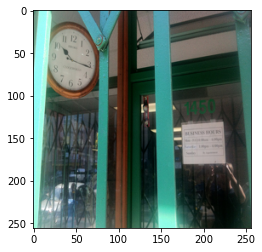

In [56]:
img = vx['image_input'][0]
plt.imshow(img)
print(img.min(),img.max())

In [57]:
for i in range(200):
    print('---',i,'---')
    print('['+vx['image_names'][i]+'], input_seq:',', '.join(['<None> {0}'.format(y) if x==0 else '<{0}> {1}'.format(co_to_w[x],y) for x,y in zip(vx['words_input'][i],vx['padding_masks'][i])]),', \t next_word:',co_to_w[vy['target_word'][i]])

--- 0 ---
[2370764.jpg], input_seq: <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <startseq> [1.] , 	 next_word: a
--- 1 ---
[2370764.jpg], input_seq: <None> [0.

[2370764.jpg], input_seq: <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <startseq> [1.], <a> [1.], <clock> [1.], <mounted> [1.], <to> [1.], <a> [1.], <wall> [1.], <.> [1.], <a> [1.], <sign> [1.], <on> [1.], <a> [1.], <wall> [1.] , 	 next_word: .
--- 13 ---
[2370764.jpg], input_seq: <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01]

--- 70 ---
[2391849.jpg], input_seq: <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <startseq> [1.], <two> [1.], <directional> [1.], <signs> [1.], <over> [1.], <highway> [1.], <.> [1.], <bridge> [1.], <over> [1.], <highway> [1.], <in> [1.] , 	 next_word: photo
--- 71 ---
[2391849.jpg], input_seq: <None> [0.01],

--- 163 ---
[2385100.jpg], input_seq: <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <startseq> [1.], <people> [1.], <walking> [1.], <a> [1.], <curved> [1.], <and> [1.], <steep> [1.], <sidewalk> [1.], <.> [1.], <round> [1.], <traffic> [1.], <signs> [1.], <on> [1.], <a> [1.], <pole> [1.], <.> [1.], <metal> [1.], <railing> [1.], <on> [1.], <inside> [1.], <of> [1.], <curb> [1.], <.> [1.], <trees> [1.], <on> [1.], <top> [1.], <of> [1.], <plant> [1.], <-> [1.], <covered> [1.], <slope> [1.], <.> [1.], <woman> [1.], <using> [1.], <open> [1.], <umbrella> [1.], <on> [1.], <sunny> [1.], <day> [1.], <.> [1.], <cars> [1.], <parked> [1.], <on> [1.], <side> [1.] , 	 next_word: of
--- 164 ---
[2385100.jpg], input_seq: <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <None> [0.01], <Non

In [58]:
# print(vx['words_input'][1])
# embedding_matrix[105]
embedding_matrix[w_to_co['..']]

array([1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
      

In [59]:
emb = Model(model.inputs[1],model.get_layer('w2v_emb').output)
emb.summary()
# model.inputs

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
words_input (InputLayer)     (None, 60)                0         
_________________________________________________________________
w2v_emb (Embedding)          (None, 60, 300)           6238500   
Total params: 6,238,500
Trainable params: 0
Non-trainable params: 6,238,500
_________________________________________________________________


In [60]:
nlp('a').vector

array([ 4.3798e-02,  2.4779e-02, -2.0937e-01,  4.9745e-01,  3.6019e-01,
       -3.7503e-01, -5.2078e-02, -6.0555e-01,  3.6744e-02,  2.2085e+00,
       -2.3389e-01, -6.8360e-02, -2.2355e-01, -5.3989e-02, -1.5198e-01,
       -1.7319e-01,  5.3355e-02,  1.6485e+00, -4.7991e-02, -8.5311e-02,
       -1.5712e-01, -6.4425e-01, -3.9819e-01,  2.7800e-01,  1.5364e-01,
        3.1678e-02,  5.5414e-02,  1.5939e-02,  3.1851e-01, -5.8979e-02,
        3.8584e-02,  1.0770e-01,  1.0410e-01, -7.7346e-02,  3.7396e-01,
       -2.1482e-01,  3.8320e-01, -2.7737e-01, -1.8352e-01, -8.3838e-01,
        3.4124e-01,  5.8164e-01,  1.8543e-01, -3.1028e-01,  1.7666e-01,
       -6.9421e-02, -3.4422e-01, -1.3665e-01, -1.0823e-01,  2.3637e-01,
       -3.2923e-01,  6.1348e-01,  1.9720e-01,  8.7123e-02,  1.0785e-01,
        3.0730e-01,  1.3757e-01,  3.0809e-01,  2.4331e-01, -2.9422e-01,
       -9.8214e-03,  5.5675e-01, -4.8880e-02,  9.9468e-02,  3.0543e-01,
       -3.7597e-01, -1.9525e-01,  4.6246e-02, -3.6675e-02,  3.40

In [61]:
emb_out = emb.predict(vx['words_input'])
display(pd.DataFrame(emb_out[1]))

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
1,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
2,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
3,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
4,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
5,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
6,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
7,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
8,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
9,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001


In [62]:
parallel_model=multi_gpu_model(model, gpus=n_gpu)
# # # model_resnet.summary()
# # # parallel_model.load_weights('./../checkpoints/sa_vgg16_3d_32x24_m32_direct.h5', by_name=True, skip_mismatch=True)

In [63]:
# lr=0.0001

parallel_model.compile(loss=loss_function,optimizer=adam,metrics=['accuracy']) #For multi GPU
parallel_model.summary()
model.inputs

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
words_input (InputLayer)        (None, 60)           0                                            
__________________________________________________________________________________________________
padding_masks (InputLayer)      (None, 60, 1)        0                                            
__________________________________________________________________________________________________
positional_encoding (InputLayer (None, 60, 512)      0                                            
____________________________________________________________________________________________

[<tf.Tensor 'image_input:0' shape=(?, 256, 256, 3) dtype=float32>,
 <tf.Tensor 'words_input:0' shape=(?, 60) dtype=float32>,
 <tf.Tensor 'padding_masks:0' shape=(?, 60, 1) dtype=float32>,
 <tf.Tensor 'positional_encoding:0' shape=(?, 60, 512) dtype=float32>]

In [64]:
pos_encoding = NM.positional_encoding(max_wlen, dimensions=512)
# ReduceLROnPlateau()
pos_enc = np.repeat(pos_encoding,repeats=train_batch_size,axis=0)

In [65]:
# mc=ModelCheckpoint(filepath='../checkpoints/vgg16_lstm_words.h5',monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
# es=EarlyStopping(patience=300,monitor='val_loss',min_delta=0.0001,mode='auto')

print('training {0} for {1} epochs'.format(model_name,EPOCHS))
# lr = K.eval(parallel_model.optimizer.lr)
# decay = 1e-3

training vgg_1dcnn_text_img_attention for 50 epochs


In [66]:
patience = 2
patience_counter = 0
min_delta = 0.001

In [67]:
def CheckSelfAttention(input_data,labels):
    _,words_input,padding_masks=input_data
    for i in range(words_input.shape[0]):
        print('-*-*-',i,'-*-*-')
        print('input_seq:',', '.join(['<None> {0}'.format(y) if x==0 else '<{0}> {1}'.format(co_to_w[x],y) for x,y in zip(words_input[i],padding_masks[i])]),', \t next_word:',co_to_w[labels[i]])
#     c1 = Model(textNet.inputs,textNet.get_layer('c1').output)
    concat_sa_1 = Model(textNet.inputs,textNet.get_layer('sa11').output)
    residual_combine_sa_1 =  Model(textNet.inputs,textNet.get_layer('residual_combine_selfattn_1').output)
    t2i_concat_1 = Model(model.inputs,model.get_layer('text2img_concat_1').output)
    
    return [
#         c1.predict(input_data),
        concat_sa_1.predict(input_data[1:]),
        residual_combine_sa_1.predict(input_data[1:]),
        t2i_concat_1.predict(input_data)
            , textNet.predict(input_data[1:])]
#     print(concat_sa_2)
    
def ReduceLROnPlateau(decay=0.5):
    old_lr = K.eval(parallel_model.optimizer.lr)
    new_lr = old_lr * decay
    return old_lr,new_lr

In [ ]:
from IPython.display import clear_output

# counter = 0

# history = model.fit_generator(train_gen
#                               ,epochs=EPOCHS
#                               ,steps_per_epoch=4
#                               ,validation_data=val_gen
#                               ,validation_steps=2
#                               ,callbacks=[mc])

hist_tl,hist_ta,hist_vl,hist_va,tt,lr_arr = [],[],[],[],[],[]
window = 64
val_window = 256
train_iterations = int(np.ceil(len(train_images_list)/train_batch_size))
val_iterations = int(np.ceil(len(test_images_list)/val_batch_size))

print('train_iterations:{0}; val_iterations:{1}'.format(train_iterations,val_iterations))
min_v_l,min_v_a,min_t_a = 100,0,0
t_l, t_a, v_l, v_a = 0, 0, 4.01, 0


train_gen = datagen(train_images_list,batch_size=train_batch_size)
val_gen = datagen(val_images_list,batch_size=val_batch_size)


for e in tqdm(np.arange(start=0,stop=EPOCHS),desc='Epoch'):
    start_time = time()
    tl,ta,vl,va = [],[],[],[]
    for im in tqdm(range(train_iterations),desc='Train_Iter',leave=False):
        tx,ty = next(train_gen)
        inputs1 = tx['image_input']
        inputs2 = tx['words_input']
        inputs3 = tx['padding_masks']
        
#         print(inputs3.shape)
        
        labels = ty['target_word']        
        for i in np.arange(len(inputs1),step=window):
            im_in,wo_in,m_in=inputs1[i:i+window],inputs2[i:i+window],inputs3[i:i+window]
            pos_enc = np.repeat(pos_encoding,repeats=im_in.shape[0],axis=0)
            loss,accuracy = parallel_model.train_on_batch([im_in,wo_in,m_in,pos_enc],labels[i:i+window])
#             concat_sa_2,concat_sa_3,concat_sa_4,textNet_output = CheckSelfAttention([inputs2[i:i+window],inputs3[i:i+window]],labels[i:i+window])            
            
            tl.append(loss)
            ta.append(accuracy)
            print('Train Iter:{0:3d}/{1}, tr_loss:{2:.4f}, tr_acc:{3:.4f} (min_v_loss:{4:.4f})'
                  .format(i+1,len(inputs1)
                          , np.mean(tl)
                          , np.mean(ta)
                          , min_v_l), end = '\r')
#             break
#         break
#     break
    for im in tqdm(range(val_iterations),desc='Val_Iter',leave=False):
        vx,vy = next(val_gen)
        inputs1 = vx['image_input']
        inputs2 = vx['words_input']
        inputs3 = vx['padding_masks']
        
        labels = vy['target_word']
        
        for i in np.arange(len(inputs1),step=val_window):
            im_in,wo_in,m_in=inputs1[i:i+val_window],inputs2[i:i+val_window],inputs3[i:i+val_window]
            pos_enc = np.repeat(pos_encoding,repeats=im_in.shape[0],axis=0)
            loss,accuracy = parallel_model.evaluate(verbose=0,x=[im_in,wo_in,m_in,pos_enc],y=labels[i:i+val_window])
            vl.append(loss)
            va.append(accuracy)
    v_l = np.round(np.mean(vl),4)
    v_a = np.round(np.mean(va),4)
    t_l = np.round(np.mean(tl),4)
    t_a = np.round(np.mean(ta),4)
    
    hist_tl.append(t_l)
    hist_ta.append(t_a)
    hist_vl.append(v_l)
    hist_va.append(v_a)
    if len(hist_tl)>=3:
        if hist_tl[-2]-hist_tl[-1]<min_delta:
            patience_counter+=1
            if patience==patience_counter:
                old_lr,lr = ReduceLROnPlateau()
                patience_counter = 0
                K.set_value(parallel_model.optimizer.lr,lr)
                K.set_value(model.optimizer.lr,lr)
    lr_arr.append(lr)
    if v_l < min_v_l:
        min_v_l = v_l
        model.save_weights(filepath='../checkpoints/{0}_vis_gen.h5'.format(model_name),overwrite=True)
#         imgNet.save_weights(filepath='../checkpoints/{0}_{1}_img_module_vis_gen.h5'.format(img_arch,text_arch),overwrite=True)
#         textNet.save_weights(filepath='../checkpoints/{0}_{1}_text_module_vis_gen.h5'.format(img_arch,text_arch),overwrite=True)
    clear_output(wait=True)
    end_time = time()
    time_taken = end_time-start_time
    tt.append(time_taken)
    with open('../tf_runs/log.csv','a') as f:
        data = '{0:3d}/{7},{1:.4f},{2:.4f},{3:.4f},{4:.4f},{6:.4f},{8:.6f}'.format(e+1, t_l, t_a, v_l, v_a, np.mean(tt),min_v_l,EPOCHS,lr)
        t = strftime("%m/%d/%Y %H:%M:%S",localtime())
        f.writelines('\n[{0}],{1},{2}'.format(t, model_name,data))
    print('E:{0:3d}/{7}, tr_loss:{1:.4f}, tr_acc:{2:.4f}, v_loss:{3:.4f}, v_acc:{4:.4f}, lr:{8:.6f} [{5:.2f} s/e] (min_v_loss:{6:.4f})'.format(e+1, t_l, t_a, v_l, v_a, np.mean(tt),min_v_l,EPOCHS,lr))

E:  1/50, tr_loss:6.0825, tr_acc:0.0000, v_loss:5.5421, v_acc:0.0000, lr:0.000100 [15169.40 s/e] (min_v_loss:5.5421)


In [ ]:
inputs1.shape

In [ ]:
# ReduceLROnPlateau()

In [ ]:
# model.save_weights(filepath='../checkpoints/{0}_vis_gen.h5'.format(model_name),overwrite=True)
# # imgNet.save_weights(filepath='../checkpoints/{0}_{1}_img_module_vis_gen.h5'.format(img_arch,text_arch),overwrite=True)
# textNet.save_weights(filepath='../checkpoints/{0}_{1}_text_module_vis_gen.h5'.format(img_arch,text_arch),overwrite=True)

In [ ]:
concat_sa_1,residual_combine_sa_1,t21_concat_1,textNet_output = CheckSelfAttention([inputs1[i:i+window],inputs2[i:i+window],inputs3[i:i+window]],labels[i:i+window])            
# 

In [ ]:
pd.options.display.max_columns=1000

In [ ]:
# display(pd.DataFrame(emb_bn[0]))

g = model.predict([inputs1[i:i+window],inputs2[i:i+window],inputs3[i:i+window],pos_enc])
plt.imshow(inputs1[i:i+window][0][:,:,::-1])
plt.show()
g.min(),g.max()

In [ ]:
g.argmax(-1)

In [ ]:
t = textNet.predict([inputs2[i:i+window],inputs3[i:i+window]])
t.min(),t.max()

In [ ]:

x,q,k,v,s,scores,beta,o = concat_sa_1
display(pd.DataFrame(x[0]))
display(pd.DataFrame(q[0]))
display(pd.DataFrame(k[0]))
display(pd.DataFrame(v[0]))
plt.imshow(s[0])
plt.show()
plt.imshow(scores[0])
plt.show()
plt.imshow(beta[0])
plt.show()
display(pd.DataFrame(o[0]))

In [ ]:
o, g1,g2= residual_combine_sa_1
print(g1,g2)
display(pd.DataFrame(o[0]))

In [ ]:
# pd.DataFrame(concat_sa_4[1])

In [ ]:
pd.DataFrame(textNet_output[0])

In [ ]:
# with open('../tf_runs/log.csv','a') as f:
#     data = '{0:3d}/{7},{1:.4f},{2:.4f},{3:.4f},{4:.4f},{6:.4f}'.format(e+1, t_l, t_a, v_l, v_a, np.mean(tt),min_v_l,EPOCHS)
#     t = strftime("%m/%d/%Y %H:%M:%S",localtime())
#     f.writelines('\n[{0}],{1},{2}'.format(t, model_name,data))
# data

In [ ]:
history = pd.DataFrame()
history['tr_acc'] = hist_ta
history['val_acc'] = hist_va
history['tr_loss'] = hist_tl
history['val_loss'] = hist_vl
display(history[['tr_acc','val_acc']].plot())
display(history[['tr_loss','val_loss']].plot())
history.to_csv('../tf_runs/{0}_x_delete.csv'.format(model_name),index=False)

# Evaluate

In [ ]:
model.load_weights('../checkpoints/{0}.h5'.format(model_name))

In [ ]:

def predict_captions(image):
    start_word = ["startseq"]
    mask = np.zeros((1,max_wlen,1))+0.001
    counter=0
    while True:
        counter-=1
        mask[:,counter,:]=1.0
        print(np.sum(mask))
        par_caps = [w_to_co[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_wlen, padding='pre',value=0)
        preds = model.predict([image, np.array(par_caps),mask])
#         print(preds.shape)
        idx = preds.argmax(-1)
        word_pred = co_to_w[idx[0]]
#         print(par_caps)
        start_word.append(word_pred)
        
        if word_pred == "endseq" or len(start_word) > max_wlen:
            break
            
    return ' '.join(start_word[1:-1])

# print('Predicted:',' '.join(out_text))

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [w_to_co["startseq"]]
    
    # start_word[0][0] = index of the starting word
    # start_word[0][1] = probability of the word predicted
    start_word = [[start, 0.0]]
    mask = np.zeros((1,max_wlen,1))+0.001
    counter=0
    while len(start_word[0][0]) < max_wlen:
        temp = []
        counter-=1
        mask[:,counter,:]=1.0
#         print(np.sum(mask))
        for s in start_word:
            
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_wlen, padding='pre', value=0)
            preds = model.predict([image, np.array(par_caps),mask])
            
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [co_to_w[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
ref_sents = []
pred_sents = []
for counter in tqdm(range(len(test_images_list))):
    testx,testy = next(test_gen)
    photo = testx['image_input'][0]
#     plt.imshow(photo)
#     plt.show()
    photo = np.expand_dims(photo,0)
    
#     print('Actual:',testy['actual_sentence'][0])
#     print()
    # st = time()
    # pred_greedy = predict_captions(photo)
    # et = time()
    # print('Greedy Predicted:{0},[{1:.2f} s]'.format(pred_greedy,et-st))
#     st = time()
    pred_bm5 = beam_search_predictions(photo,beam_index=5)
#     et = time()
#     print('Beam-5 Predicted:{0},[{1:.2f} s]'.format(pred_bm5,et-st))
    ref_sents.append(testy['actual_sentence'][0])
    pred_sents.append(pred_bm5)
    if counter==10:
        break

In [ ]:

# st = time()
# pred_greedy = predict_captions(photo)
# et = time()
# print('Greedy Predicted:{0},[{1:.2f} s]'.format(pred_greedy,et-st))

# st = time()
# pred_bm3 = beam_search_predictions(photo,beam_index=3)
# et = time()
# print('Beam-3 Predicted:{0},[{1:.2f} s]'.format(pred_bm3,et-st))

# st = time()
# pred_bm5 = beam_search_predictions(photo,beam_index=5)
# et = time()
# print('Beam-5 Predicted:{0},[{1:.2f} s]'.format(pred_bm5,et-st))

# st = time()
# pred_bm7 = beam_search_predictions(photo,beam_index=7)
# et = time()
# print('Beam-7 Predicted:{0},[{1:.2f} s]'.format(pred_bm7,et-st))
pd.set_option('display.max_colwidth', -1)
df_pred = pd.DataFrame()
df_pred['Ref'] = ref_sents
df_pred['Pred'] = pred_sents
df_pred

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
rouge = Rouge()
reference = nlp(str(vy['actual_sentence'][0]))
reference = [[str(x) for x in list(reference)]]


# candidate = nlp(pred_greedy)
# candidate = [str(x) for x in list(candidate)]
# df_result['greedy'] = [sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))]

# candidate = nlp(pred_bm3)
# candidate = [str(x) for x in list(candidate)]
# df_result['bm3'] = [sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))]
row = []
for i in range(len(ref_sents)):
    r = ref_sents[i]
    c = pred_sents[i]
    reference = nlp(str(r))
    reference = [[str(x) for x in list(reference)]]
    candidate = nlp(str(c))
    candidate = [str(x) for x in list(candidate)]
    row.append([sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
                          ,sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
                          ,sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
                          ,sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
                          ,rouge.get_scores(hyps=c,refs=r)[0]['rouge-l']['f']])


# candidate = nlp(pred_bm7)
# candidate = [str(x) for x in list(candidate)]
# df_result['bm7'] = [sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))]
df_result = pd.DataFrame(row)
df_result.columns = ['BLEU-1','BLEU-2','BLEU-3','BLEU-4','ROUGE-L']
df_result=df_result.round(3)

In [ ]:
# ref_sents,pred_sents
df_result.mean()

In [ ]:
pd.DataFrame(row)

In [ ]:

reference = str(vy['actual_sentence'][0])
# reference = [[str(x) for x in list(reference)]]
candidate = pre
# candidate = [str(x) for x in list(candidate)]
ro = rouge.get_scores(hyps=candidate,refs=reference)
ro[0]['ROUGE-L']['f']

In [ ]:
pd.DataFrame(ro[0]).T

In [ ]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor

In [ ]:
def calc_scores(ref, hypo):
    """
    ref, dictionary of reference sentences (id, sentence)
    hypo, dictionary of hypothesis sentences (id, sentence)
    score, dictionary of scores
    """
    scorers = [
#         (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
#         (Meteor(),"METEOR"),
        (Rouge(), "ROUGE_L"),
        (Cider(), "CIDEr")
    ]
    final_scores = {}
    for scorer, method in scorers:
        score, scores = scorer.compute_score(ref, hypo)
        if type(score) == list:
            for m, s in zip(method, score):
                final_scores[m] = s
        else:
            final_scores[method] = score
    return final_scores 

In [ ]:
calc_scores(ref=ref_sents,hypo=pred_sents)

In [ ]:
from nlgeval import NLGEval
nlgeval = NLGEval()  # loads the models


In [ ]:
references = []
hypothesis = []
import pickle
import numpy as np
with open('../dataset/chestxray_cnn_attention_decoder_ref_sents.p', 'rb') as file:
    # store the data as binary data stream
    references=pickle.load(file)
with open('../dataset/chestxray_cnn_attention_decoder_pred_sents.p', 'rb') as file:
    # store the data as binary data stream
    hypothesis=pickle.load(file)
    
references=np.array(references)
hypothesis=np.array(hypothesis)
references[:2],hypothesis[:2]

In [ ]:
refs=np.expand_dims(ref_sents,1)
# hyps=np.expand_dims(hypothesis,0)
refs=refs.tolist()
# hyps=hyps.tolist()
hypothesis = pred_sents
len(refs),len(hypothesis)

In [ ]:
metrics_dict = nlgeval.compute_metrics(refs, hypothesis)

In [ ]:
r = {idx: strippedlines for (idx, strippedlines) in enumerate(refs)}

In [ ]:
len(r)

In [ ]:
h = {idx: [lines.strip()] for (idx, lines) in enumerate(hypothesis)}

In [ ]:
len(h)

In [ ]:
refs[0],hypothesis[0]

In [ ]:
from nlgeval import compute_individual_metrics


In [ ]:
metrics_dict = compute_individual_metrics(refs[1], hypothesis[1])

In [ ]:
import pandas as pd
df = pd.DataFrame.from_dict(metrics_dict,orient='index').T

In [ ]:
df = pd.DataFrame()
for i in range(300):
    m = nlgeval.compute_individual_metrics(refs[i], hypothesis[i])
    d = pd.DataFrame.from_dict(m,orient='index').T
    df = df.append(d)
    print(np.around(i*100//300,2),end='\r')

In [ ]:
df.shape

In [ ]:
df.mean()

In [ ]:
testx,testy = next(test_gen)
plt.imshow(testx['image_input'][1])

In [ ]:
testx.keys()

In [ ]:
for layer  in model.layers:
    print(layer.name)

In [ ]:
model_img2_text_ca_1 = Model(model.inputs,model.get_layer('img2text_1').output)
model_img2_text_ca_2 = Model(model.inputs,model.get_layer('img2text_2').output)
model_img2_text_ca_3 = Model(model.inputs,model.get_layer('img2text_3').output)
model_img2_text_ca_4 = Model(model.inputs,model.get_layer('img2text_4').output)
# model_text2_img_ca_1 = Model(model.inputs,model.get_layer('text2img_1').output)
# model_text2_img_ca_2 = Model(model.inputs,model.get_layer('text2img_2').output)
# model_text2_img_ca_3 = Model(model.inputs,model.get_layer('text2img_3').output)
# model_text2_img_ca_4 = Model(model.inputs,model.get_layer('text2img_4').output)

In [ ]:
fi2t_1,bi2t_1 = model_img2_text_ca_1.predict(testx)
fi2t_2,bi2t_2 = model_img2_text_ca_2.predict(testx)
fi2t_3,bi2t_3 = model_img2_text_ca_3.predict(testx)
fi2t_4,bi2t_4 = model_img2_text_ca_4.predict(testx)
# ft2i_1,bt2i_1 = model_text2_img_ca_1.predict(testx)
# ft2i_2,bt2i_2 = model_text2_img_ca_2.predict(testx)
# ft2i_3,bt2i_3 = model_text2_img_ca_3.predict(testx)
# ft2i_4,bt2i_4 = model_text2_img_ca_4.predict(testx)

In [ ]:
fi2t_1.shape,bi2t_1.shape

In [ ]:
# bt2i_add = bt2i_1+bt2i_1+bt2i_1+bt2i_1
bi2t_add = bi2t_1+bi2t_1+bi2t_1+bi2t_1

In [ ]:
# bt2i_add.shape
bi2t_add.shape

In [ ]:
# for j in range(bt2i_add.shape[0]):    
#     i=testx['words_input'][j][-1]
#     if i!=0:
#         print(j,':',co_to_w[i])
#         plt.imshow(bt2i_add[j])
#         plt.show()
for j in range(bi2t_add.shape[0]):    
    i=testx['words_input'][j][-1]
    if i!=0:
        print(j,':',co_to_w[i])
        plt.imshow(bi2t_add[j])
        plt.show()

In [ ]:

for i in range(pd.DataFrame(bt2i_add[j]).shape[0]):
    print('Row:{0},Max Col Idx:{1},Max Col Value:{2}'.format(i,np.argmax(bt2i_add[j][i]),np.max(bt2i_add[j][i])))

In [ ]:
plt.imshow(cv2.resize(bt2i_add[j][57].reshape((8,8)),(256,256),cv2.INTER_CUBIC),cmap='jet')

In [ ]:
plt.imshow(testx['image_input'][1])
plt.imshow(cv2.resize(bt2i_add[j][57].reshape((8,8)),(256,256),cv2.INTER_CUBIC),cmap='jet',alpha=0.2)

In [ ]:
testx['words_input'].shape